In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/franco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('tweets_hate_speech.csv')
df.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive


In [ ]:
df.describe()

,tweet,label
count,24783,24783
unique,24783,3
top,!!! RT @mayasolovely: As a woman you shouldn't...,offensive
freq,1,19190


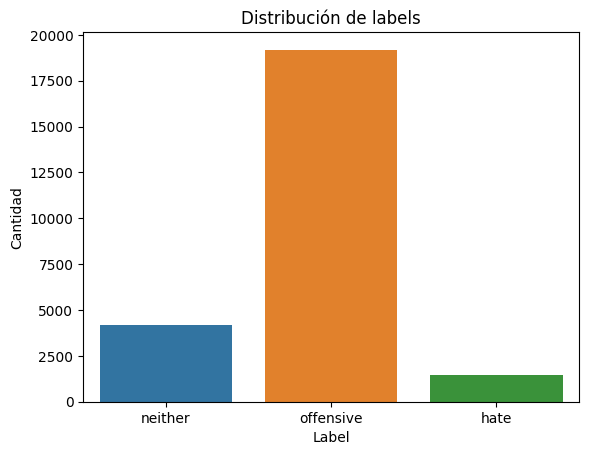

In [ ]:
# Distribución por sentimiento
sns.countplot(data=df, x='label',
              hue='label', legend=False)
plt.title("Distribución de labels")
plt.xlabel("Label")
plt.ylabel("Cantidad")
plt.show()

In [ ]:
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    return " ".join(tokens)

df['clean_text'] = df['tweet'].apply(clean_text)

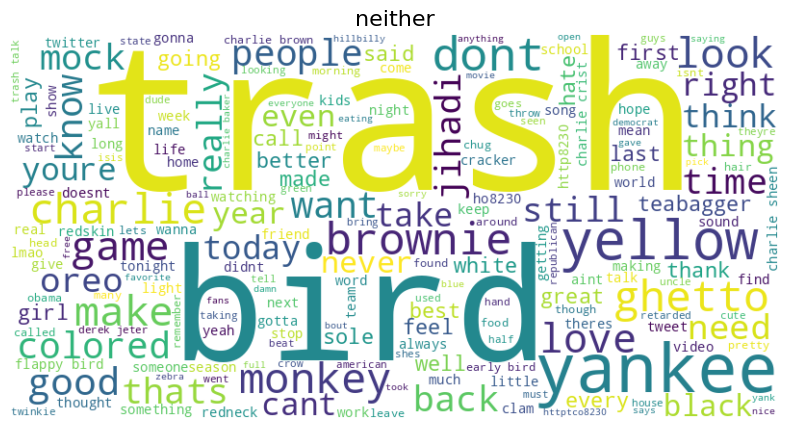

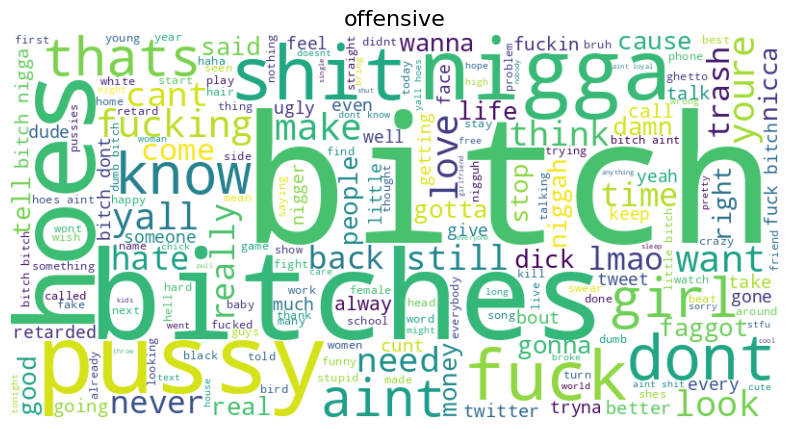

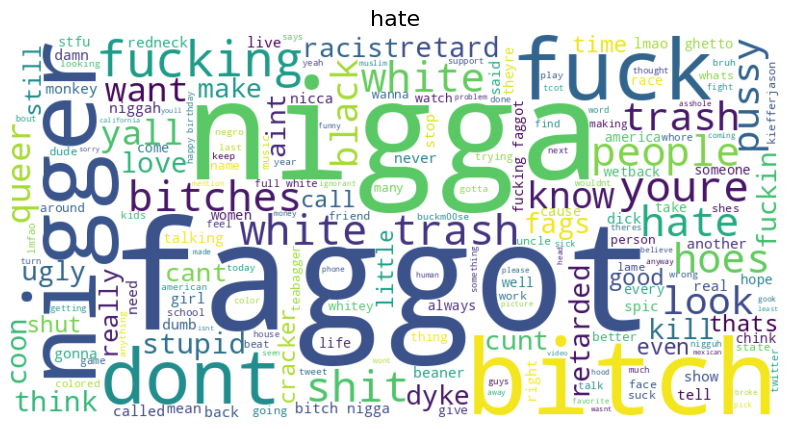

In [ ]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label in df['label'].unique():
    subset = df[df['label'] == label]
    plot_wordcloud(subset['clean_text'], title=label)

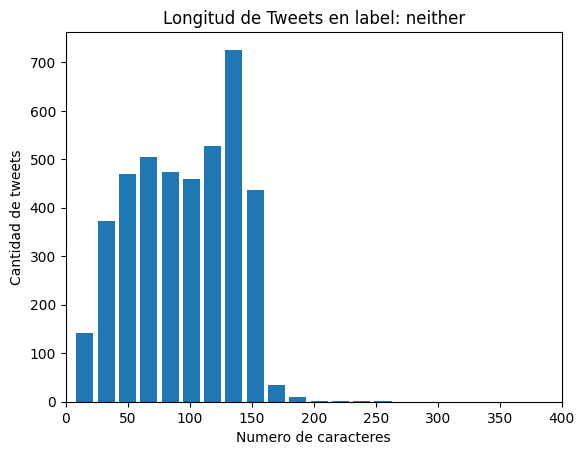

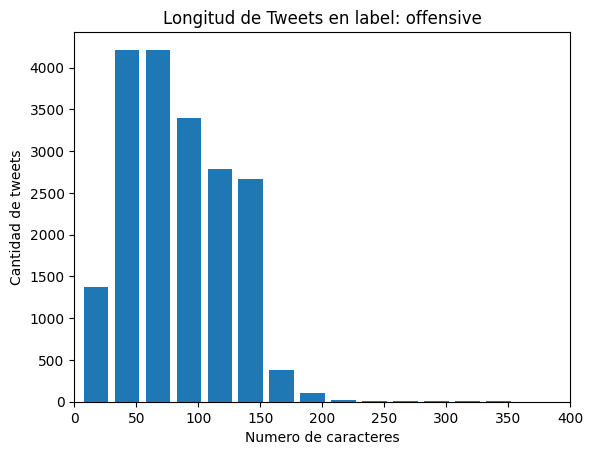

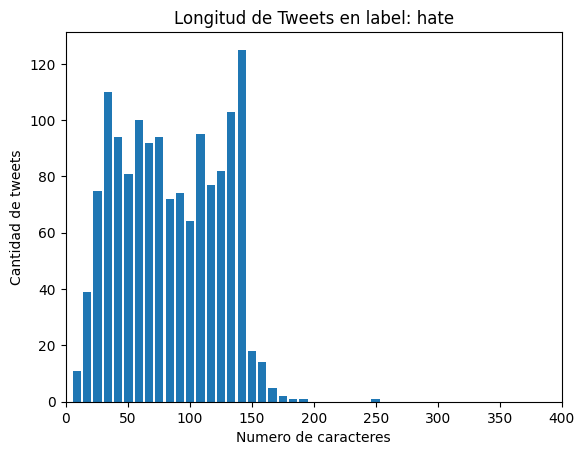

In [ ]:
df['text_length'] = df['tweet'].apply(len)

# Histograma por sentimiento
for label in df['label'].unique():
    subset = df[df['label'] == label]
    #print(subset['text_length'].describe())
    plt.hist(subset['text_length'], bins=30, alpha=1, label=str(label), rwidth=0.8)
    plt.xlim(0, 400)
    plt.title("Longitud de Tweets en label: " + str(label))
    plt.xlabel("Numero de caracteres")
    plt.ylabel("Cantidad de tweets")
    plt.show()

#sns.dogplot(data=df, x='label', y='text_length', palette='pastel', hue='label')

In [ ]:
def most_common_words(texts, n=10):
    all_words = " ".join(texts).split()
    common_words = Counter(all_words).most_common(n)
    return pd.DataFrame(common_words, columns=['Palabra', 'Frecuencia'])

# Top palabras por sentimiento
for sentiment in df['label'].unique():
    print(f"\nPalabras más comunes en tweets {sentiment.upper()}:")
    common_df = most_common_words(df[df['label'] == sentiment]['clean_text'])
    print(common_df)


Palabras más comunes en tweets NEITHER:
   Palabra  Frecuencia
0    trash         672
1     like         301
2     bird         287
3  yankees         281
4  charlie         256
5   yellow         213
6     dont         169
7    birds         167
8   monkey         111
9   ghetto         109

Palabras más comunes en tweets OFFENSIVE:
   Palabra  Frecuencia
0    bitch        7903
1  bitches        2989
2     like        2292
3     hoes        2266
4    pussy        2018
5     dont        1486
6     fuck        1285
7     shit        1184
8     aint        1089
9    nigga        1053

Palabras más comunes en tweets HATE:
   Palabra  Frecuencia
0    bitch         207
1   faggot         186
2     like         166
3    nigga         138
4    white         126
5     fuck         121
6    trash         112
7   nigger         110
8  fucking          94
9     dont          94


# Punto 2

In [ ]:
df['clean_text'].head

<bound method NDFrame.head of 0        mayasolovely woman shouldnt complain cleaning ...
1                       mleew17 dats coldtyga cuffin place
2        urkindofbrand dawg 80sbaby4life ever fuck bitc...
3                    cganderson vivabased look like tranny
4        shenikaroberts shit hear might true might fake...
                               ...                        
24778    yous muthafin 8220lifeasking 20pearls coreyema...
24779    youve gone broke wrong heart baby drove rednec...
24780             young buck wanna nigguh like aint fuckin
24781                        youu wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: clean_text, Length: 24783, dtype: object>

## Variables de salida

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded']=label_encoder.fit_transform(df['label'])
#neither  1
#offensive 2
#hate 0

In [ ]:
df['label_encoded'].value_counts()

label_encoded
2    19190
1     4163
0     1430
Name: count, dtype: int64

In [ ]:
df['label'].value_counts()

label
offensive    19190
neither       4163
hate          1430
Name: count, dtype: int64

In [ ]:
y = df['label']

## Bag of words

In [ ]:
# Bag of Words
bow = CountVectorizer(max_features=5000)
X_bow = bow.fit_transform(df['clean_text']).toarray()

In [ ]:
X_bow.shape

(24783, 5000)

In [ ]:
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(24783, 5000))

## TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()

In [ ]:
X_tfidf.shape

(24783, 5000)

In [ ]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(24783, 5000))

## Balance del conjunto de datos

<Axes: xlabel='count', ylabel='label'>

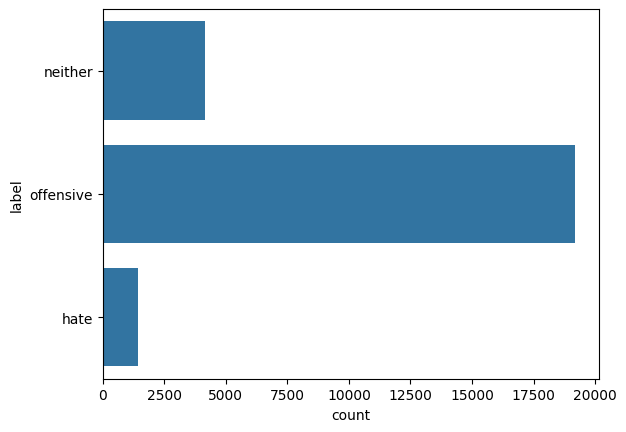

In [ ]:
sns.countplot(data=df, y=y)

In [ ]:
# SMOTE para balancear ambos conjuntos de datos
smote = SMOTE()

# Para BoW
X_bow_res, y_bow_res = smote.fit_resample(X_bow, y)

# Para TF-IDF
X_tfidf_res, y_tfidf_res = smote.fit_resample(X_tfidf, y)

<Axes: xlabel='count', ylabel='label'>

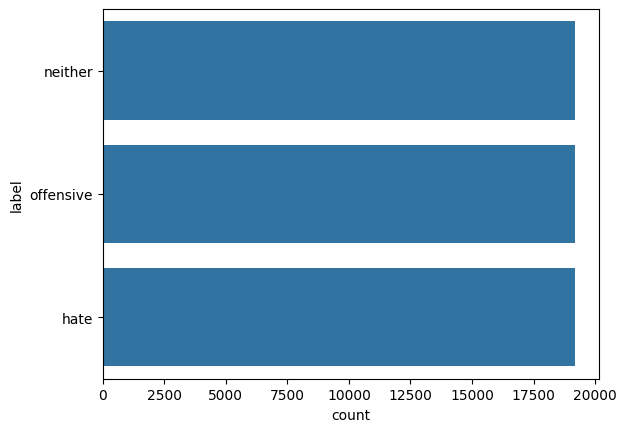

In [48]:
sns.countplot(y=y_bow_res)

#### **División dataset en train/test**

In [ ]:
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow_res, y_bow_res, test_size=0.2, random_state=20)
X_bow_test, X_bow_valid, y_bow_test, y_bow_valid = train_test_split(X_bow_test, y_bow_test, test_size=0.5, random_state=20)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf_res, y_tfidf_res, test_size=0.2, random_state=20)
X_tfidf_test, X_tfidf_valid, y_tfidf_test, y_tfidf_valid = train_test_split(X_tfidf_test, y_tfidf_test, test_size=0.5, random_state=20)

In [ ]:
parametros_k_vecinos = [3, 5, 7, 9]
parametros_naive = ['Multinomial', 'Gaussian']
parametros_random_forest = [50, 100, 150]

models = {
    'K-Vecinos 3': KNeighborsClassifier(n_neighbors=3),
    'K-Vecinos 5': KNeighborsClassifier(n_neighbors=5),
    'K-Vecinos 7': KNeighborsClassifier(n_neighbors=7),
    'K-Vecinos 9': KNeighborsClassifier(n_neighbors=9),
    'Naive Bayes Multi': MultinomialNB(),
    'Naive Bayes Gauss': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=20),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=20),
    'Random Forest': RandomForestClassifier(n_estimators=150, random_state=20)
}

#### **Entrenar y evaluar modelos**

In [ ]:
# Guardar los resultados
resultados_accuracy = []

def evaluate_models(X_train, X_test, y_train, y_test, vectorizer_name):
    print(f"\n Resultados con {vectorizer_name}:\n" + "-"*40)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n Modelo: {name}")
        print("Accuracy:", acc)
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

         # Guardar en la lista global
        resultados_accuracy.append({
            'Modelo': name,
            'Vectorización': vectorizer_name,
            'Accuracy': acc
        })

In [ ]:
# Evaluación con BoW
evaluate_models(X_bow_train, X_bow_test, y_bow_train, y_bow_test, "Bag of Words")

# Evaluación con TF-IDF
evaluate_models(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

#### **Resultados**

In [ ]:
df_results = pd.DataFrame(resultados_accuracy)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Modelo', y='Accuracy', hue='Vectorización', palette='Set2')
plt.title('Comparación de Accuracy por Modelo y Vectorización')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()